In [17]:
import platform
print(f"platform.python_version(): {platform.python_version()}")

import os
import scipy
import numpy as np
from glob import glob
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

# 確認GPU是否可用
gpus = tf.config.experimental.list_physical_devices("GPU")
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

platform.python_version(): 3.9.13
tf.config.list_physical_devices('GPU'): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


mfcc .npy檔案路徑陣列

In [18]:
npy_file_path_list: list = glob(f"..\\data\\mfccEduVer\\*.npy")
print(f"type(npy_file_path_list): {type(npy_file_path_list)}")
print(f"len(npy_file_path_list): {len(npy_file_path_list)}")
# npy_file_path_list

type(npy_file_path_list): <class 'list'>
len(npy_file_path_list): 45167


讀取npy_file_path_list裡面每一個npy_file_path 轉成mfcc 放入mfcc_matrix_list

In [19]:
mfcc_matrix_list = list()

for npy_file_path in tqdm(npy_file_path_list):
    mfcc_matrix = np.load(file=npy_file_path)
    mfcc_matrix_list.append(mfcc_matrix)

mfcc_matrix_list = np.array(mfcc_matrix_list)
print(f"type(mfcc_matrix_list): {type(mfcc_matrix_list)}")
print(f"mfcc_matrix_list.shape: {mfcc_matrix_list.shape}")  
# mfcc_matrix_list

100%|██████████| 45167/45167 [00:07<00:00, 5648.17it/s]

type(mfcc_matrix_list): <class 'numpy.ndarray'>
mfcc_matrix_list.shape: (45167, 13, 44)


標準化

In [20]:
scaler = StandardScaler()
# 因為標準器只能fit 2維的資料所以要將3維的mfcc資料集reshape成2維
# mfcc_data_nums: k
# mfcc_row: n
# mfcc_column: m
# (k, n, m) => (k * n, m)
scaler.fit(mfcc_matrix_list.reshape((mfcc_matrix_list.shape[0] * mfcc_matrix_list.shape[1], mfcc_matrix_list.shape[2])))

mfcc_matrix_list_scaled = []
for mfcc in mfcc_matrix_list:
    mfcc_matrix_list_scaled.append(scaler.transform(mfcc))

# 將list()轉換成np.array()
mfcc_matrix_list_scaled = np.array(mfcc_matrix_list_scaled)

print(f"type(mfcc_matrix_list_scaled): {type(mfcc_matrix_list_scaled)}")
print(f"mfcc_matrix_list_scaled.shape: {mfcc_matrix_list_scaled.shape}")

# 不要印出 ipynb會爆炸
# mfcc_matrix_list_scaled

type(mfcc_matrix_list_scaled): <class 'numpy.ndarray'>
mfcc_matrix_list_scaled.shape: (45167, 13, 44)


資料拼音標籤

In [22]:
label_pinyin_list = []

for npy_file_path in npy_file_path_list:
    label_pinyin = npy_file_path.split("_")[1]
    label_pinyin_list.append(label_pinyin)

# 將list()轉換成np.array()
label_pinyin_list = np.array(label_pinyin_list)

print(f"type(label_pinyin_list): {type(label_pinyin_list)}")
print(f"label_pinyin_list.shape: {label_pinyin_list.shape}")
# label_pinyin_list

type(label_pinyin_list): <class 'numpy.ndarray'>
label_pinyin_list.shape: (45167,)


標籤轉換字典 key: pinyin key: int

In [23]:
sample_list = glob(f"..\\data\\samplePinyinEdu\\Male\\*.wav")

label_dic: dict = {}
for i in range(len(sample_list)):
    label = sample_list[i][sample_list[i].find("_") + 1:sample_list[i].find(".wav")]
    label_dic[label] = i

print(f"type(label_dic): {type(label_dic)}")
print(f"len(label_dic): {len(label_dic)}")
# label_dic

type(label_dic): <class 'dict'>
len(label_dic): 1467


轉換成int的標籤

In [33]:
label_int_list = []
for label_pinyin in label_pinyin_list:
    label_int = label_dic[label_pinyin]
    label_int_list.append(label_int)

label_int_list = np.array(label_int_list)
print(f"label_int_list.shape: {label_int_list.shape}")
# label_int_list

label_int_list.shape: (45167,)


模型

In [25]:
def get_cnn_model(input_shape, num_classes, learning_rate=0.001, num_filters=32, dense_units=256):
    cnn_model = Sequential()

    # 第一層捲積層
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same', input_shape=input_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 第二層捲積層
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 2, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 第三層捲積層
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Conv2D(num_filters * 4, kernel_size=(3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 展平
    cnn_model.add(Flatten())
    
    # 第一層全連接層
    cnn_model.add(Dense(dense_units))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    
    # 第二層全連接層
    cnn_model.add(Dense(dense_units * 2))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    
    # 第三層全連接層(長度同為1467個label)
    cnn_model.add(Dense(num_classes))
    
    # 表示為機率
    cnn_model.add(Activation('softmax'))

    cnn_model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return cnn_model

讀取最佳超參數

In [26]:
best_params = json.load(open(f"..\\grid_search\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

基本參數

In [27]:
channel = 1
verbose = 2
num_classes = len(label_dic)
test_size = 0.2
mfcc_dim_1 = mfcc_matrix_list.shape[1]
mfcc_dim_2 = mfcc_matrix_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


資料切割

In [28]:
X = mfcc_matrix_list_scaled
y = label_int_list

# 將int label轉換成二進制one hot標籤
y_one_hot = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=test_size, random_state=42)

X_train = X_train.reshape(X_train.shape[0], mfcc_dim_1, mfcc_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], mfcc_dim_1, mfcc_dim_2, channel)

模型訓練

In [29]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes, learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/300
283/283 - 9s - loss: 5.1511 - accuracy: 0.1427 - val_loss: 6.1923 - val_accuracy: 0.0387 - 9s/epoch - 31ms/step
Epoch 2/300
283/283 - 6s - loss: 3.5939 - accuracy: 0.2886 - val_loss: 3.6985 - val_accuracy: 0.2691 - 6s/epoch - 21ms/step
Epoch 3/300
283/283 - 6s - loss: 2.9436 - accuracy: 0.3751 - val_loss: 3.0791 - val_accuracy: 0.3588 - 6s/epoch - 21ms/step
Epoch 4/300
283/283 - 6s - loss: 2.5150 - accuracy: 0.4427 - val_loss: 2.8264 - val_accuracy: 0.3996 - 6s/epoch - 21ms/step
Epoch 5/300
283/283 - 6s - loss: 2.1783 - accuracy: 0.5013 - val_loss: 2.6259 - val_accuracy: 0.4333 - 6s/epoch - 21ms/step
Epoch 6/300
283/283 - 6s - loss: 1.8868 - accuracy: 0.5607 - val_loss: 2.5222 - val_accuracy: 0.4593 - 6s/epoch - 21ms/step
Epoch 7/300
283/283 - 6s - loss: 1.6123 - accuracy: 0.6167 - val_loss: 2.4034 - val_accuracy: 0.4641 - 6s/epoch - 21ms/step
Epoch 8/300
283/283 - 6s - loss: 1.3442 - accuracy: 0.6760 - val_loss: 2.3515 - val_accuracy: 0.4778 - 6s/epoch - 21ms/step
Epoch 9/

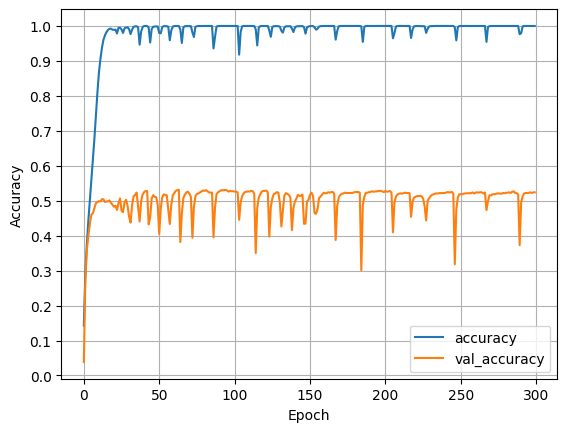

In [37]:
accuracies = model_train_info.history['accuracy']
val_accuracies = model_train_info.history['val_accuracy']

plt.plot(list(range(epochs)), accuracies, label = 'accuracy')
plt.plot(list(range(epochs)), val_accuracies, label = 'val_accuracy')
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, epochs + 1, 50)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [31]:
print(f"資料: {mfcc_matrix_list_scaled.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (45167, 13, 44)
最高準確率: 0.5311047434806824


In [32]:
model.save(f".\\cnn_model.h5")